In [184]:
import pandas as pd
from collections import defaultdict
import pandas as pd
import pickle
import numpy as np
import sklearn
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 150

## Data preparation

In [185]:
#loading the data
tickets = pd.read_csv('tickets.csv')

In [186]:
tickets.head()

,ticket
0,eit-prismadm01.tgna.tegna.com: System or agent has recently restarted
1,"ATL-NELLC-N9K-2: Interface state changed to operationally down: 436212736, Name: Ethernet1/11 P950-3_C6-1; previous state was up (1)"
2,vaqupdtoms01: Device Failed Availability Check: UDP - SNMP
3,"test-vm-01: VMware: VM CPU Usage Has Exceeded Threshold (95%), currently (100.0%)"
4,NTNX-local-ds-19SM6J290326-B: Device Failed Availability Check: Component device 9872 is not available (NTNX-local-ds-19SM6J290326-B); Reason: Av...


In [187]:
#dimensionality of the data
tickets.shape

(5446, 1)

In [188]:
#Check for NAs
tickets.isnull().values.any()

False

In [189]:
ts = list(tickets['ticket'])
sources = [t.split(':')[0] for t in ts]

from collections import defaultdict
def count_and_sort(iterable):
    """Returns number of unique sources and their amount sorted"""
    count = defaultdict(int)
    for val in iterable:
        count[val] += 1
    counts_sorted = sorted(list(count.items()), key=lambda x: x[1], reverse=True)
    return len(counts_sorted), counts_sorted

In [190]:
#Exploring sources
count_and_sort(sources)

(2129,
 [('bausch-db', 31),
  ('eit-priwotfrd03.tgna.tegna.com', 26),
  ('etm-priwomsrd03.tgna.tegna.com', 26),
  ('etm-priwomsrd02.tgna.tegna.com', 25),
  ('etm-priwomsrd05.tgna.tegna.com', 24),
  ('dxc-db', 24),
  ('SQL01', 23),
  ('dxc-app', 22),
  ('etm-priwomsrd01.tgna.tegna.com', 22),
  ('eit-priwotfrd01.tgna.tegna.com', 22),
  ('ETM-PRICTXVDA04.tgna.tegna.com', 21),
  ('etm-priwomsrd06.tgna.tegna.com', 20),
  ('etm-priwomsrd04.tgna.tegna.com', 20),
  ('CPCSQL.CPCMGT.LOCAL', 20),
  ('eit-priwotfrd02.tgna.tegna.com', 19),
  ('ad-prime-2', 18),
  ('iad01vm29-03', 17),
  ('AD-FRANKFURT-2.syniti-cloud.lcl', 16),
  ('itochu-db', 16),
  ('eit-priwotfrd04.tgna.tegna.com', 16),
  ('pmusweb10.PMUS.local', 15),
  ('METRICSTREAM-SW01.SJC1.GDT.com', 15),
  ('etm-prictxvda03.tgna.tegna.com', 15),
  ('CPCJCYWPAPP01.CPCMGT.LOCAL', 14),
  ('pmusweb05.PMUS.local', 14),
  ('iad01vm28-02', 14),
  ('iad01vm27-02', 14),
  ('iad01vm25-05', 14),
  ('etm-prictxvda01.tgna.tegna.com', 13),
  ('URCATLWDB02

Given amount of sources and their names, it is not feasible to make clusterization of tickets using sources

In [191]:
msgs = [t.split(':',1)[1] for t in ts if len(t.split(':')) > 1]

#Get the amount of the unique messages
len(set(msgs))

2437

In [192]:
#Split the messages from sources
tspairs_raw = [t.split(':',1) for t in ts]

set([len(tp) for tp in tspairs_raw])

tspairs = [tp if len(tp) == 2 else [tp[0], ''] for tp in tspairs_raw]

set([len(tp) for tp in tspairs])

tspairs

[['eit-prismadm01.tgna.tegna.com', ' System or agent has recently restarted'],
 ['ATL-NELLC-N9K-2',
  ' Interface state changed to operationally down:  436212736, Name: Ethernet1/11 P950-3_C6-1; previous state was up (1)'],
 ['vaqupdtoms01', ' Device Failed Availability Check: UDP - SNMP'],
 ['test-vm-01',
  ' VMware: VM CPU Usage Has Exceeded Threshold (95%), currently (100.0%)'],
 ['NTNX-local-ds-19SM6J290326-B',
  ' Device Failed Availability Check: Component device 9872 is not available  (NTNX-local-ds-19SM6J290326-B); Reason: Availability App'],
 ['IntegrateStaging',
  ' Device Failed Availability Check: Component device 18416 is not available ; Reason: At least one ancestor of IntegrateStaging (ID=> 18416) has'],
 ['iad01vm22-04', ' Required service not running: Tomcat7'],
 ['dataconstructionserver',
  ' Device Failed Availability Check: Component device 18431 is not available ; Reason: At least one ancestor of dataconstructionserver (ID='],
 ['etm-priwomsrd05.tgna.tegna.com', ' 

In [193]:
### Gather the collected data into the data frame

tickets['source'] = [t[0] for t in tspairs]

tickets['message'] = [t[1].strip(' ') for t in tspairs]

tickets.iloc[100:200]

tickets['message'][123].strip(' ')

'VMware: VM CPU Usage Has Exceeded Threshold (95%), currently (95.81%)'

In [194]:
#For basic exploration
### The messages have some hierarchical structure, with ':' being the node delimiter between parent and child.

msgs = list(tickets['message'])

msg0 = [m.split(':')[0] for m in msgs]

count_and_sort(msg0)

def find_beginning(msg_iter, beginning):
    return [m for m in msg_iter if beginning == m.split(':')[0]]

find_beginning(msgs, 'T')

['T:\\: File system usage exceeded critical threshold: Limit: 90.0%, Actual: 90.02%',
 'T:\\: File system usage exceeded critical threshold: Limit: 90.0%, Actual: 90.46%',
 'T:\\: File system usage exceeded critical threshold: Limit: 90.0%, Actual: 98.30%']

In [195]:
msgs = list(tickets['message'])

In [196]:
test = msgs[3070:3080]
test

['System or agent has recently restarted',
 'System or agent has recently restarted',
 'Required service not running: Server',
 'Required service not running: Tomcat7',
 'Device Failed Availability Check: Component device 18597 is not available ; Reason: At least one ancestor of db31_prod_shared_u01 (ID=> 18',
 'Host Resource: Physical Memory has exceeded threshold 90%. The current value is 91%.',
 'Device Failed Availability Check: Component device 4002 is not available',
 'Host Resource: CPU has exceeded threshold 90%. The current value is 91.0%.',
 "The 'Sync Host_c1536a0a' service is NOT running",
 'Required service not running: Tomcat7']

In [197]:
#Lets prepare messages for processing
import re
import string

def preprocess_message(msg):
    msg = msg.lower() #make all text lower case
    msg = re.sub('[^A-Za-z0-9 ]+', '', msg)   
    msg = re.sub('[0-9]+', '<num>', msg) #substitute numbers by <num>
    msg = re.sub('[%s]' % re.escape(string.punctuation), '', msg) #remove punctuation
   #msg = re.sub('\w*\d\w*', '', msg) #remove words containing numbers
    msg.rstrip('')
    return msg

In [198]:
[preprocess_message(t) for t in test]

['system or agent has recently restarted',
 'system or agent has recently restarted',
 'required service not running server',
 'required service not running tomcatnum',
 'device failed availability check component device num is not available  reason at least one ancestor of dbnumprodsharedunum id num',
 'host resource physical memory has exceeded threshold num the current value is num',
 'device failed availability check component device num is not available',
 'host resource cpu has exceeded threshold num the current value is num',
 'the sync hostcnumanuma service is not running',
 'required service not running tomcatnum']

In [199]:
prep = [preprocess_message(m) for m in msgs]

In [200]:
tickets['prep'] = prep

In [201]:
tickets.isnull().values.any()

False

In [202]:
tickets

,ticket,source,message,prep
0,eit-prismadm01.tgna.tegna.com: System or agent has recently restarted,eit-prismadm01.tgna.tegna.com,System or agent has recently restarted,system or agent has recently restarted
1,"ATL-NELLC-N9K-2: Interface state changed to operationally down: 436212736, Name: Ethernet1/11 P950-3_C6-1; previous state was up (1)",ATL-NELLC-N9K-2,"Interface state changed to operationally down: 436212736, Name: Ethernet1/11 P950-3_C6-1; previous state was up (1)",interface state changed to operationally down num name ethernetnum pnumcnum previous state was up num
2,vaqupdtoms01: Device Failed Availability Check: UDP - SNMP,vaqupdtoms01,Device Failed Availability Check: UDP - SNMP,device failed availability check udp snmp
3,"test-vm-01: VMware: VM CPU Usage Has Exceeded Threshold (95%), currently (100.0%)",test-vm-01,"VMware: VM CPU Usage Has Exceeded Threshold (95%), currently (100.0%)",vmware vm cpu usage has exceeded threshold num currently num
4,NTNX-local-ds-19SM6J290326-B: Device Failed Availability Check: Component device 9872 is not available (NTNX-local-ds-19SM6J290326-B); Reason: Av...,NTNX-local-ds-19SM6J290326-B,Device Failed Availability Check: Component device 9872 is not available (NTNX-local-ds-19SM6J290326-B); Reason: Availability App,device failed availability check component device num is not available ntnxlocaldsnumsmnumjnumb reason availability app
...,...,...,...,...
5441,ORCRICVMWPRO5: Device Failed Availability Check: UDP - SNMP,ORCRICVMWPRO5,Device Failed Availability Check: UDP - SNMP,device failed availability check udp snmp
5442,dcvCenter01.hsftdc.local: Host Resource: Physical Memory has exceeded threshold 93%. The current value is 94%.,dcvCenter01.hsftdc.local,Host Resource: Physical Memory has exceeded threshold 93%. The current value is 94%.,host resource physical memory has exceeded threshold num the current value is num
5443,AD-FRANKFURT-2.syniti-cloud.lcl: Active Directory (ntds) LDAP Bind Time exceeded the threshold (3 ms).,AD-FRANKFURT-2.syniti-cloud.lcl,Active Directory (ntds) LDAP Bind Time exceeded the threshold (3 ms).,active directory ntds ldap bind time exceeded the threshold num ms
5444,phx1-p02-p-mw01: System or agent has recently restarted,phx1-p02-p-mw01,System or agent has recently restarted,system or agent has recently restarted


In [203]:
words = defaultdict(int)

In [204]:
for msg in tickets['prep']:
    for word in msg.split():
        words[word] += 1

In [205]:
#Sort words to find the most frequent ones
words_sorted = sorted(list(words.items()), key=lambda x: x[1], reverse=True)

In [206]:
len(words_sorted)

1013

In [207]:
words_sorted[100:350]

[('error', 59),
 ('established', 58),
 ('above', 58),
 ('and', 55),
 ('power', 53),
 ('swap', 50),
 ('instance', 49),
 ('requests', 44),
 ('received', 44),
 ('sync', 40),
 ('for', 40),
 ('storage', 39),
 ('a', 39),
 ('ntds', 39),
 ('ldap', 39),
 ('bind', 39),
 ('ms', 39),
 ('queue', 38),
 ('length', 38),
 ('number', 37),
 ('logical', 37),
 ('dropped', 37),
 ('type', 36),
 ('hrstoragefixeddisk', 36),
 ('total', 36),
 ('errors', 36),
 ('unit', 35),
 ('network', 35),
 ('bgp', 34),
 ('peer', 34),
 ('b', 33),
 ('vaquvapcomnum', 33),
 ('used', 33),
 ('intelr', 33),
 ('mb', 32),
 ('inum', 32),
 ('gigabit', 32),
 ('vaqupapesxnumsephorauscom', 31),
 ('serial', 31),
 ('g', 31),
 ('reporting', 31),
 ('packets', 31),
 ('tax', 30),
 ('calculator', 30),
 ('trap', 30),
 ('cisco', 29),
 ('prior', 29),
 ('linux', 29),
 ('vlan', 27),
 ('portchannelnum', 27),
 ('interrupts', 27),
 ('peers', 25),
 ('aggregate', 25),
 ('sqlnum', 25),
 ('reals', 25),
 ('ethernet', 24),
 ('supply', 24),
 ('ginum', 24),
 ('gl

In [208]:
frequent = [w for w, f in words_sorted if f >= 10]

In [209]:
filtered

['device',
 'availability',
 'failed',
 'check',
 'threshold',
 'exceeded',
 'system',
 'available',
 'component',
 'running',
 'agent',
 'recently',
 'restarted',
 'reason',
 'service',
 'required',
 'id',
 'state',
 'tomcatnum',
 'value',
 'host',
 'current',
 'usage',
 'currently',
 'least',
 'one',
 'ancestor',
 'resource',
 'snmp',
 'udp',
 'cpu',
 'interface',
 'app',
 'critical',
 'previous',
 'changed',
 'down',
 'name',
 'operationally',
 'up',
 'memory',
 'limit',
 'unavailable',
 'file',
 'filesystem',
 'vmware',
 'physical',
 'actual',
 'disk',
 'parent',
 'server',
 'ethernetnum',
 'did',
 'marked',
 'pagessecond',
 'below',
 'sql',
 'microsoft',
 'icmp',
 'ping',
 'vm',
 'idrac',
 'pkts',
 'utilization',
 'problem',
 'cache',
 'hit',
 'ratio',
 'database',
 'powershell',
 'time',
 'status',
 'percent',
 'ma',
 'connection',
 'pages',
 'pauses',
 'second',
 'private',
 'numerrors',
 'windows',
 'active',
 'directory',
 'communication',
 'error',
 'established',
 'above',
 

In [210]:
#collected meaningless words
words_to_remove = ['num', 'has', 'not', 'is', 'or', 'the', 'of', 'at', 'on', 'to', 
                   'was', 'been', 'as', 'per', 'and', 'for', 'a', 'the', 'in']
#to remove names of the disks
for word in filtered:
    if len(word) == 1 and word != ' ':
        words_to_remove.append(word)

#remove meaningless words from set of words
for word in words_to_remove:
    if word in filtered:
        filtered.remove(word)

In [211]:
words_to_remove

['num',
 'has',
 'not',
 'is',
 'or',
 'the',
 'of',
 'at',
 'on',
 'to',
 'was',
 'been',
 'as',
 'per',
 'and',
 'for',
 'a',
 'the',
 'in']

In [212]:
#Clean preprocessed messages in whole table
pat = '|'.join(r"\b{}\b".format(x) for x in words_to_remove)
tickets['prep'] = tickets['prep'].str.replace(pat, '')
tickets['prep']

0                                                                                      system  agent  recently restarted
1                            interface state changed  operationally down   name ethernetnum pnumcnum previous state  up 
2                                                                             device failed availability check udp  snmp
3                                                                    vmware vm cpu usage  exceeded threshold  currently 
4       device failed availability check component device    available  ntnxlocaldsnumsmnumjnumb reason availability app
                                                              ...                                                       
5441                                                                          device failed availability check udp  snmp
5442                                                 host resource physical memory  exceeded threshold   current value  
5443                            

In [213]:
word_indices = {word: index for index, word in enumerate(filtered)}

In [214]:
word_indices

{'device': 0,
 'availability': 1,
 'failed': 2,
 'check': 3,
 'threshold': 4,
 'exceeded': 5,
 'system': 6,
 'available': 7,
 'component': 8,
 'running': 9,
 'agent': 10,
 'recently': 11,
 'restarted': 12,
 'reason': 13,
 'service': 14,
 'required': 15,
 'id': 16,
 'state': 17,
 'tomcatnum': 18,
 'value': 19,
 'host': 20,
 'current': 21,
 'usage': 22,
 'currently': 23,
 'least': 24,
 'one': 25,
 'ancestor': 26,
 'resource': 27,
 'snmp': 28,
 'udp': 29,
 'cpu': 30,
 'interface': 31,
 'app': 32,
 'critical': 33,
 'previous': 34,
 'changed': 35,
 'down': 36,
 'name': 37,
 'operationally': 38,
 'up': 39,
 'memory': 40,
 'limit': 41,
 'unavailable': 42,
 'file': 43,
 'filesystem': 44,
 'vmware': 45,
 'physical': 46,
 'actual': 47,
 'disk': 48,
 'parent': 49,
 'server': 50,
 'ethernetnum': 51,
 'did': 52,
 'marked': 53,
 'pagessecond': 54,
 'below': 55,
 'sql': 56,
 'microsoft': 57,
 'icmp': 58,
 'ping': 59,
 'vm': 60,
 'idrac': 61,
 'pkts': 62,
 'utilization': 63,
 'problem': 64,
 'cache': 

In [215]:
# Now we make one hot encoding of the messages
import numpy as np
num_features = len(word_indices)
def encode_message(msg: str) -> np.array:
    vector = np.zeros(num_features)
    for word in msg.split():
        if word not in word_indices:
            continue
        idx = word_indices[word]
        vector[idx] = 1
    return vector

In [216]:
tickets['embedding'] = tickets['prep'].map(lambda preproc_msg: encode_message(preproc_msg))

In [217]:
tickets['prep'][170]

'pages  second  exceeded  threshold  pagessecond  value  currently  pagessecond'

In [218]:
tickets['embedding'][170]

array([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [219]:
embeddings = tickets['embedding']

In [220]:
tickets.isnull().values.any()

False

In [221]:
X = np.stack(embeddings.to_numpy())

X.shape

(5446, 199)

In [222]:
X[100]

array([1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [232]:
number_of_clusters = [i for i in range(2, 30)]
silhouette_list = []
for num in number_of_clusters:
    clustering_tmp = KMeans(n_clusters=num, random_state = 27).fit(X)
    labels_tmp = clustering_tmp.labels_
    silhouette_tmp = sklearn.metrics.silhouette_score(X, labels_tmp, metric='euclidean', random_state=15)
    silhouette_list += [silhouette_tmp]

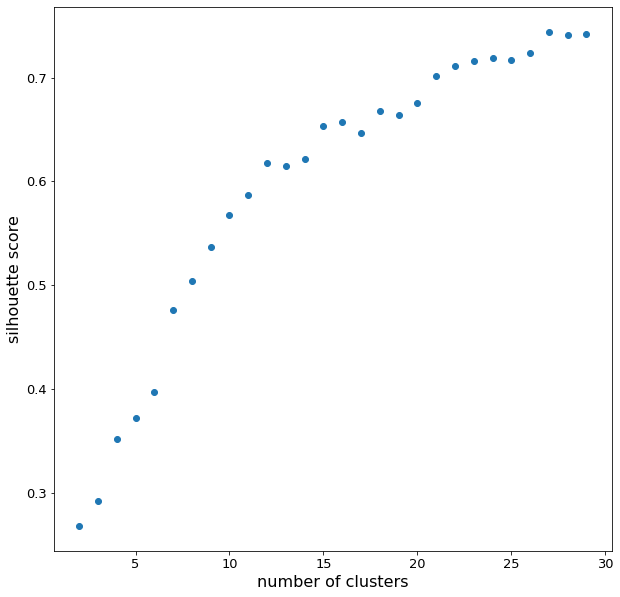

In [233]:
# visualization to choose number of clusters
fig, ax = plt.subplots()
ax.set_ylabel('silhouette score', fontsize=16)
ax.set_xlabel('number of clusters', fontsize=16)
ax.scatter(number_of_clusters, silhouette_list)
plt.show()

In [256]:
'''We should choose the number of clusters. According to Silhouette average scores
we can choose the optimal amount of clusters. But it would be helpful to discuss with a client'''
#clustering = DBSCAN(eps=0.1, min_samples=3).fit(X)
cls_nmb = 15 #Try to come up with some optimal solution (not so many clusters) and then check if it performs well

clustering = KMeans(n_clusters=cls_nmb, random_state = 27).fit(X)

labels = clustering.labels_

tickets['label'] = labels

silhouette_final = sklearn.metrics.silhouette_score(X, labels, metric='euclidean', random_state=15)
silhouette_final

0.6535090484894374

In [257]:
def combined_messages(number):
    combine_messages = ' '.join(list(tickets[tickets['label'] == number]['prep']))
    return combine_messages

In [258]:
set(list(tickets[tickets['label'] == 3]['message']))

{'Device Failed Availability Check: TCP Port (80)',
 'Device Failed Availability Check: UDP - SNMP',
 'Device Failed Availability Check: UDP/SNMP check requested but invalid or no credential was specified.'}

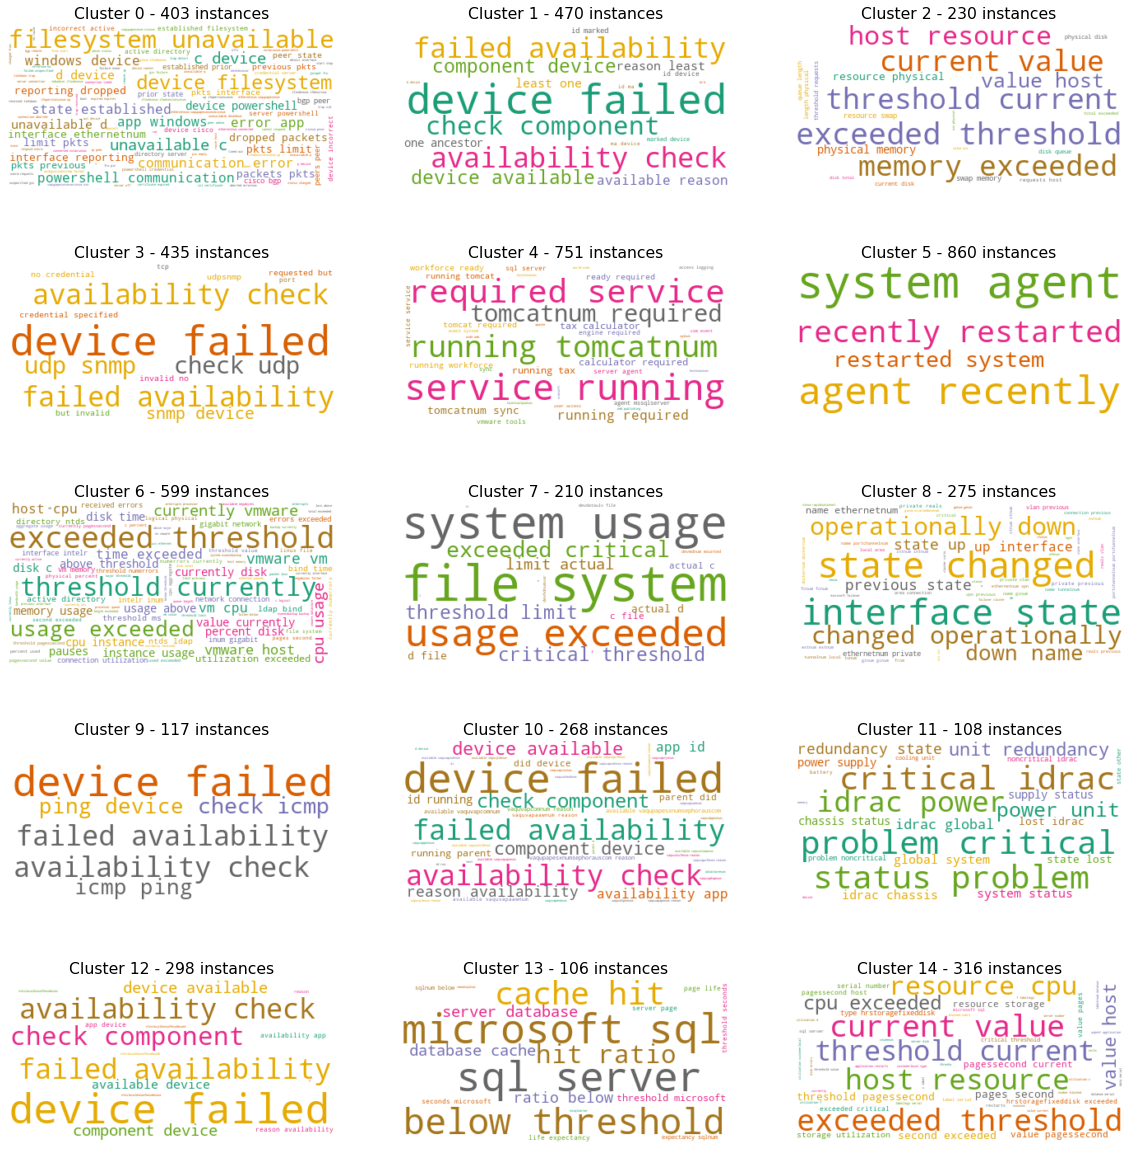

In [259]:
#Visualization of clusters through wordclouds
from wordcloud import WordCloud

wc = WordCloud(stopwords='english', background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

# Reset the output dimensions

cluster_numbers = [int(i) for i in range(0,cls_nmb)]

# Create subplots for each cluster
plt.rcParams['figure.figsize'] = [20, 30]
amount_list = []
for index, number in enumerate(cluster_numbers):
    wc.generate(combined_messages(number))
    amount = len(list(tickets[tickets['label'] == number]['prep']))
    plt.subplot(7, 3, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f'Cluster {number} - {amount} instances')
    amount_list.append(amount)
    
plt.show()

The wordclouds above help to estimate how clusters of messages differ from each other. The resulting clustering seems quite useful, because each cluster have different key words, except 4 clusters that share the phrase 'device failed'. But even these clusters seem different enough from the first glance

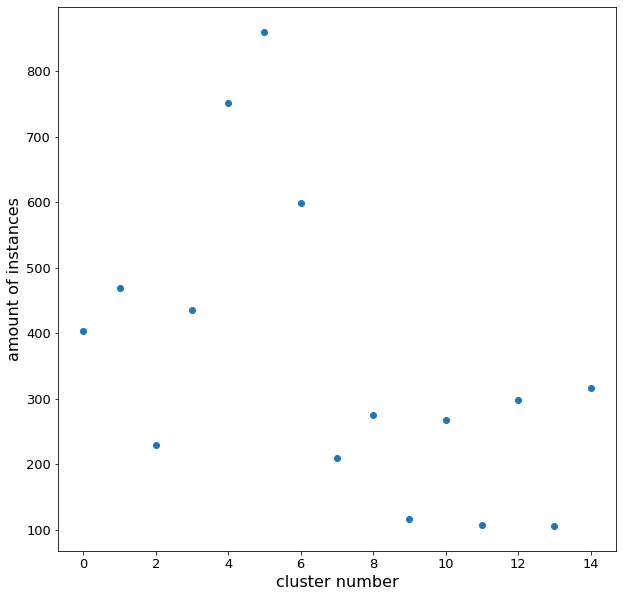

In [263]:
# create a figure and axes
fig, ax = plt.subplots()
# label x-axis and y-axis
ax.set_ylabel('amount of instances', fontsize=16)
ax.set_xlabel('cluster number', fontsize=16)
# function to plot and show graph
ax.scatter(cluster_numbers, amount_list)
plt.rcParams['figure.figsize'] = [10, 10] 
plt.show()

The graph above shows that the destribution of messages is quite even (between 200 - 500 elements per cluster) with exception of outliers (3 about 100 and 2 about 800). 

## Tables with results

Below I created a table with brief description of each cluster. I looked at unique elements of the column 'prep' for each cluster and extracted the main topics 

In [284]:
#the sets are gnerated using following line of code:
set(list(tickets[tickets['label'] == 5]['message']))

{'System or agent has recently restarted'}

In [278]:
explanations = ['Messages connected with BGP, powershell comunication error, "Juniper: FRU PIC, Interface reporting dropped packets"','All messages share the main message "Device Failed Availability Check: Component device ... is not available" with reason', 'Memory errors', '"Device Failed Availability Check" related to TCP and UDP without reason', 'Errors tell that device or service is not running',
       'System or agent has recently restarted', 'Value is above threshold', 'Value exceeded critical threshold', 'Only messages with type "Interface state changed"', 'Only messages with type "Device Failed Availability Check: ICMP Ping"' , 'Only messages with type "Device Failed Availability Check" with reason', 'Messages with iDRAC problems', 
       'Only messages with type "Device Failed Availability Check" without a reason', 'Only messages with type "Microsoft: SQL Server"',
       'Values exceeded critical values, current value is given']
len(explanation)

15

In [279]:
report_list = {'Cluster number' : cluster_numbers, 'Amount of instances': amount_list, 'Description of messages': explanations}
report = pd.DataFrame(report_list)
report

,Cluster number,Amount of instances,Description of messages
0,0,403,"Messages connected with BGP, powershell comunication error, ""Juniper: FRU PIC, Interface reporting dropped packets"""
1,1,470,"All messages share the main message ""Device Failed Availability Check: Component device ... is not available"" with reason"
2,2,230,Memory errors
3,3,435,"""Device Failed Availability Check"" related to TCP and UDP without reason"
4,4,751,Errors tell that device or service is not running
5,5,860,System or agent has recently restarted
6,6,599,Value is above threshold
7,7,210,Value exceeded critical threshold
8,8,275,"Only messages with type ""Interface state changed"""
9,9,117,"Only messages with type ""Device Failed Availability Check: ICMP Ping"""


Using information about clusters presented above the specialist can navigate in the table below (label - number of the cluster)

In [266]:
tickets = tickets.drop('embedding', axis = 1)
tickets

,ticket,source,message,prep,label
0,eit-prismadm01.tgna.tegna.com: System or agent has recently restarted,eit-prismadm01.tgna.tegna.com,System or agent has recently restarted,system agent recently restarted,5
1,"ATL-NELLC-N9K-2: Interface state changed to operationally down: 436212736, Name: Ethernet1/11 P950-3_C6-1; previous state was up (1)",ATL-NELLC-N9K-2,"Interface state changed to operationally down: 436212736, Name: Ethernet1/11 P950-3_C6-1; previous state was up (1)",interface state changed operationally down name ethernetnum pnumcnum previous state up,8
2,vaqupdtoms01: Device Failed Availability Check: UDP - SNMP,vaqupdtoms01,Device Failed Availability Check: UDP - SNMP,device failed availability check udp snmp,3
3,"test-vm-01: VMware: VM CPU Usage Has Exceeded Threshold (95%), currently (100.0%)",test-vm-01,"VMware: VM CPU Usage Has Exceeded Threshold (95%), currently (100.0%)",vmware vm cpu usage exceeded threshold currently,6
4,NTNX-local-ds-19SM6J290326-B: Device Failed Availability Check: Component device 9872 is not available (NTNX-local-ds-19SM6J290326-B); Reason: Av...,NTNX-local-ds-19SM6J290326-B,Device Failed Availability Check: Component device 9872 is not available (NTNX-local-ds-19SM6J290326-B); Reason: Availability App,device failed availability check component device available ntnxlocaldsnumsmnumjnumb reason availability app,12
...,...,...,...,...,...
5441,ORCRICVMWPRO5: Device Failed Availability Check: UDP - SNMP,ORCRICVMWPRO5,Device Failed Availability Check: UDP - SNMP,device failed availability check udp snmp,3
5442,dcvCenter01.hsftdc.local: Host Resource: Physical Memory has exceeded threshold 93%. The current value is 94%.,dcvCenter01.hsftdc.local,Host Resource: Physical Memory has exceeded threshold 93%. The current value is 94%.,host resource physical memory exceeded threshold current value,2
5443,AD-FRANKFURT-2.syniti-cloud.lcl: Active Directory (ntds) LDAP Bind Time exceeded the threshold (3 ms).,AD-FRANKFURT-2.syniti-cloud.lcl,Active Directory (ntds) LDAP Bind Time exceeded the threshold (3 ms).,active directory ntds ldap bind time exceeded threshold ms,6
5444,phx1-p02-p-mw01: System or agent has recently restarted,phx1-p02-p-mw01,System or agent has recently restarted,system agent recently restarted,5
